<a href="https://colab.research.google.com/github/isidora00/MU_Wine_Predictions/blob/main/01_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje vrste i kvaliteta vina iz njegovih fizičkih svojstava

Kvalitet vina je ključan za konzumere kao i za proizvođače u vinskoj industriji. Sertifikacija kvaliteta proizvoda postaje sve važnija za povećanje tržišne vrednosti i prodaje. Tradicionalno, testiranje kvaliteta vina vrši se na kraju proizvodnog procesa, što je vremenski zahtevno i resursno intenzivno. Ovaj pristup zahteva angažovanje brojnih stručnjaka za procenu, što može biti skupo i subjektivno, s obzirom na različite mišljenja i standarde procene.

Kako bi se poboljšala efikasnost i tačnost u proceni kvaliteta vina, možemo koristiti objektivne metode koje mogu smanjiti zavisnost od ljudskih procena. Različite karakteristike vina mogu uticati na njegov kvalitet, ali nisu sve od njih relevantne za precizno predviđanje.
U ovom projektu koristimo mašinsko učenje da bismo identifikovali ključne karakteristike vina i omogućili preciznije i efikasnije ocenjivanje njegovog kvaliteta.

## Skup podataka
Skup podataka koji ćemo koristiti za ovaj problem je javno dostupan na sledećem linku https://archive.ics.uci.edu/dataset/186/wine+quality. Ovaj skup podataka sadrži 6497 primeraka portugalskog vina *vinho verde*. Podaci su nebalansirano raspodeljeni između dve vrste vina: 75% uzoraka su bela vina (4898), dok 25% čine crvena vina (1599). Svaki uzorak je opisan sa 11 fizičko-hemijskih karakteristika, koje su sve neprekidne veličine: fiksna kiselost, hlapiva kiselost, koncentracija limunske kiseline, sadržaj rezidualnog šećera, koncentracije hlorida, sadržaj slobodnog sumpor-dioksida, ukupan sadržaj sumpor-dioksida, gustina, pH, koncentracije sulfata i sadržaj alkohola. Svakom uzorku dodeljene su i dve oznake: stil vina (crveno ili belo) i subjektivna ocena (celi brojevi između 0 i 10) koju je odredio panel od tri somelijera.

In [1]:
pip -q install seaborn ucimlrepo plotly

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, model_selection, metrics
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance

In [3]:
# Fetch dataset
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non


Vidimo da nemamo nedostajuće vrednosti ni u jednoj koloni. Sledi kratak opis svih raspoloživih karakteristika vina:
- **fixed_acidity**: Nehlapljive kiseline koje se ne isparavaju lako.
- **volatile_acidity**: Visoka koncentracija octene kiseline u vinu koja može dovesti do neprijatnog ukusa sirćeta.
- **citric_acid**: Deluje kao konzervans koji povećava kiselost. U malim količinama, dodaje svežinu i ukus vinima.
- **residual_sugar**: Količina šećera koja ostaje nakon što fermentacija završi. Ključno je postići savršen balans između slatkoće i kiselosti. Važno je napomenuti da vina sa više od 45 g/l su slatka.
- **chlorides**: Količina soli u vinu.
- **free_sulfur_dioxide**: Sprečava rast mikroba i oksidaciju vina.
- **total_sulfur_dioxide**: Količina slobodnih i vezanih oblika SO2.
- **density**: Slađa vina imaju veću gustinu.
- **pH**: Opisuje nivo kiselosti na skali od 0 do 14. Većina vina se kreće između 3 i 4 na pH skali.
- **sulphates**: Dodatak u vinu koji doprinosi nivou SO2 i deluje kao antimikrobni i antioksidantni agent.
- **alcohol**: Prisutan u malim količinama u vinima.

## Pretprocesiranje podataka
### Podela podataka na skup za obučavanje i skup za testiranje
Na samom početku podatke delimo na skup za obučavanje i skup za testiranje koji sadrži 25% podataka i koji neće učestvovati u treniranju modela.

In [4]:
# Podela na trening, validacioni i test skup
X = df.features
y = df.targets
X_train_validation, X_test, y_train_validation, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42, stratify=y_train_validation)
y_train = np.array(y_train).ravel()
y_train_validation = np.array(y_train_validation).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

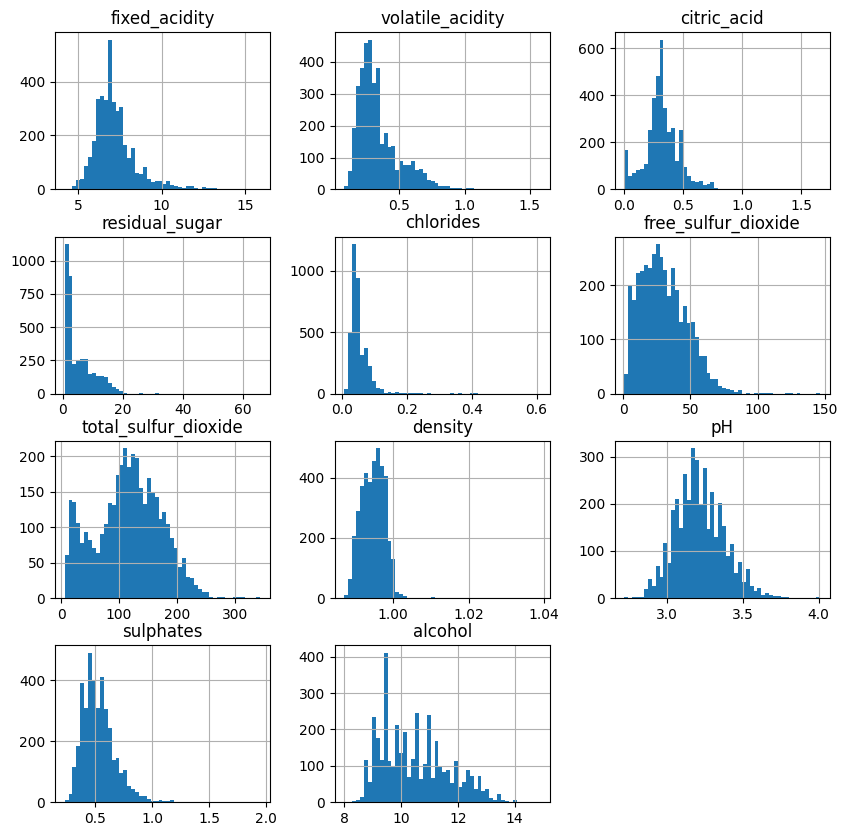

In [5]:
pd.DataFrame(X_train).hist(figsize=(10,10),bins=50)
plt.show()

## Broj instanci po kategoriji vina
Na grafiku vidimo da su instance vina nejednako raspodeljene među kategorijama.

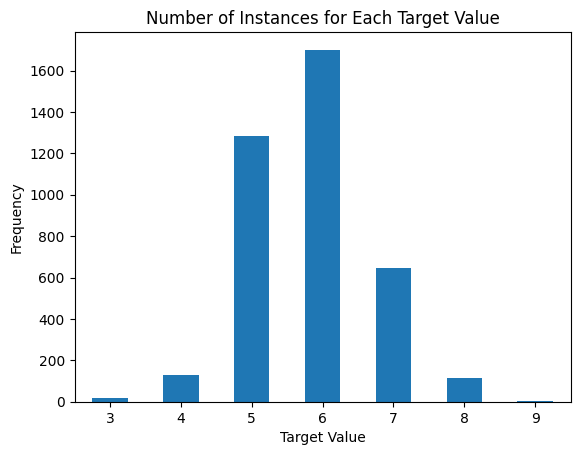

In [6]:
value_counts = pd.DataFrame(y_train).value_counts().sort_index()
# Plot
ax = value_counts.plot(kind='bar')

ax.set_xticklabels([x[0] for x in value_counts.index] )
plt.xlabel('Target Value')
plt.ylabel('Frequency')      #
plt.title('Number of Instances for Each Target Value')
plt.xticks(rotation=0)
plt.show()

### Selekcija atributa

Selekcija atributa je tehnika koja omogućava odabir najboljeg skupa atributa za modeliranje i predviđanje. Cilj je identifikovati koji atributi donose najviše informacija i time poboljšati performanse modela.

Koristimo koeficijente korelacije između svih parova atributa u skupu podataka. Korelacija meri kako su atributi međusobno povezani:

Vrednost 1 označava jaku pozitivnu linearnu korelaciju, vrednost -1 označava jaku negativnu korelaciju dok vrednost 0 ukazuje na odsustvo korelacije, što znači da ne postoji značajna povezanost između atributa.

Na primer, atributi poput fiksne kiselosti i gustine imaju visoku korelaciju sa koeficijentom od 0.46, što sugeriše da su ti atributi značajno povezani. Nasuprot tome, atributi kao što su hloridi i koncentracija limunske kiseline imaju nižu korelaciju sa koeficijentom od 0.04, što znači da su manje povezani.

Razumevanje ovih korelacija može pomoći u optimizaciji modela tako što ćemo eliminisati redundantne ili manje korisne atributa.

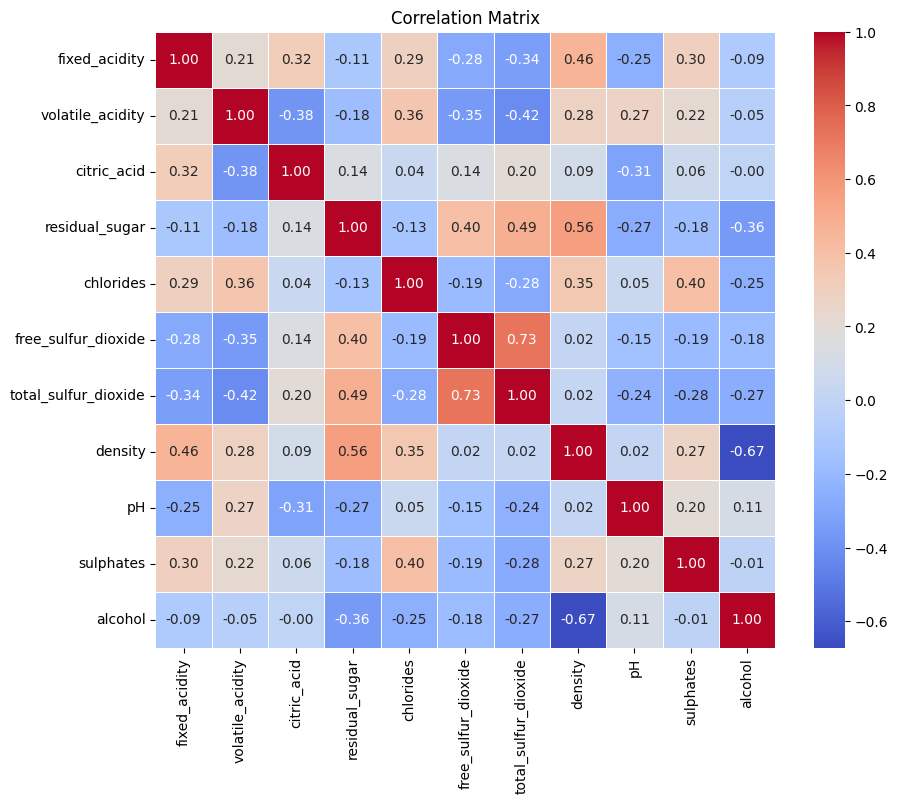

In [7]:
correlation_matrix = pd.DataFrame(X_train).corr() # koefcijijenti korelacija atributa
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) # toplotna mapa za prikaz koeficijenata
plt.title('Correlation Matrix')
plt.show()

## Standardizacija atributa
Sledeći korak je standardizacija atributa. Bitna napomena je da skalare za standardizaciju učimo na skupu za treniranje, dok skaliranje primenjujemo i na test skupu.

In [8]:
# Standardizacija atributa
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### Redukcija dimenzionalnosti
Za sve metode koje ćemo koristiti, primenićemo tehniku redukcije dimenzionalnosti. Ova tehnika je korisna za smanjenje broja atributa u podacima, čime se poboljšava efikasnost modela, smanjuje složenost i potencijalno otklanjaju redudantni podaci. Dimenzija na koju ćemo redukovati podatke biće definisana kao hiperparametar modela, što znači da će se optimizovati tokom procesa obuke modela kako bi se postigao najbolji rezultat.

## Modeli

Na modelima linearne regresije, slučajne šume, svm, naive-bayes i adaboost-a ćemo unakrsnom validacijom na trening skupu naći najbolje hiperparametre, parametre i ocene rada modela. Na osnovu tih ocena, izabraćemo najbolji model i njega evaluirati konačno na test skupu.

Koristićemo PCA za smanjenje dimenzionalnosti podataka i GridSearchCV za optimizaciju modela, s obzirom na to da imamo ograničen broj podataka.

### Linearna regresija sa regularizacijom

In [9]:
# Hiperparametri
pipeline_lr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('regressor', linear_model.Ridge())
])

param_grid_lr = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'regressor__alpha': [0.1, 1, 10, 100]
}

In [10]:
# Unakrsna validacija na trening skupu
grid_search_lr = model_selection.GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best score for Linear Regression: ", grid_search_lr.best_score_)
print("Best parameters for Linear Regression: ", grid_search_lr.best_params_)

Best score for Linear Regression:  -0.5500217327000916
Best parameters for Linear Regression:  {'pca__n_components': 11, 'regressor__alpha': 10}


In [11]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_lr = grid_search_lr.best_estimator_
y_val_pred_lr = best_model_lr.predict(X_val)

In [12]:
# Iscrtavanje tačnih i predviđenih vrednosti
def plot_predicted_actual_values(y,y_pred):

    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5, color='blue', edgecolors='k', s=50)

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')

    plt.grid(True)
    plt.show()

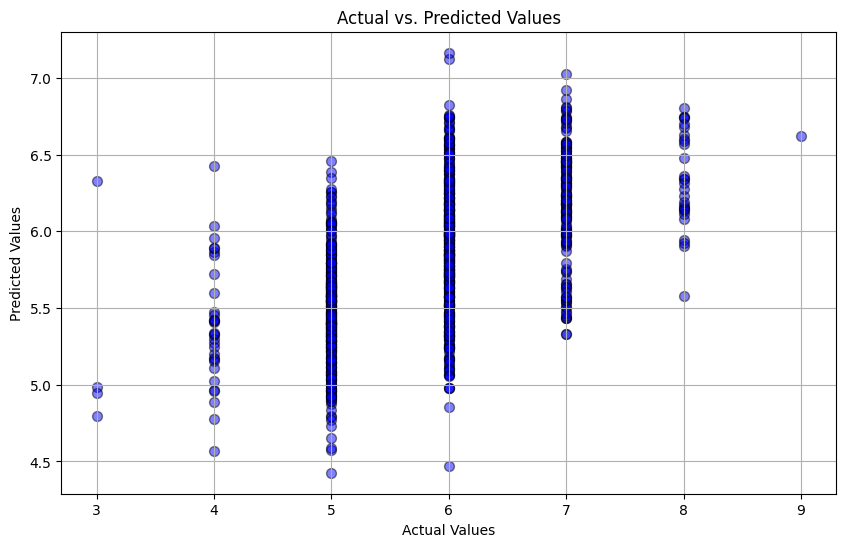

In [13]:
plot_predicted_actual_values(y_val,y_val_pred_lr)

In [14]:
models = []
# Ispis grešaka za model
def print_errors(y, y_pred, model_name):
    # Mean Squared Error
    mse = metrics.mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)

    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y, y_pred)
    print("Mean Absolute Error: ", mae)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)

    # R-squared
    r2 = metrics.r2_score(y, y_pred)
    print("R-squared: ", r2)

    # Median Absolute Error
    median_ae = metrics.median_absolute_error(y, y_pred)
    print("Median Absolute Error: ", median_ae)

    # Explained Variance Score
    explained_variance = metrics.explained_variance_score(y, y_pred)
    print("Explained Variance Score: ", explained_variance)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print("Mean Absolute Percentage Error: {:.2f}%".format(mape))

    model = {
        'Model' : model_name,
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Median_AE': median_ae, 'Explained_Variance': explained_variance, 'MAPE': mape
    }

    return model

### Provera parametara na toplotnoj mapi
Možemo da koristimo toplotne mape da se uverimo da pretražujemo dobre skupove parametara. Iz ovih rezultata vidimo da možemo pretraživati i veće vrednosti za *regressor__alpha* parametar.

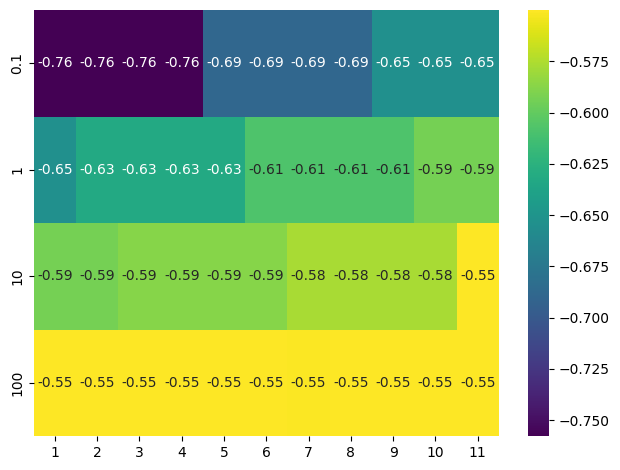

In [15]:
cv_results = pd.DataFrame(grid_search_lr.cv_results_)

cv_test_score = cv_results['mean_test_score'].values.reshape(4, 11)

alfas = [0.1, 1, 10, 100]
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

sb.heatmap(cv_test_score, xticklabels=n_components, yticklabels=alfas, cmap='viridis', annot=True, fmt='.2f')


plt.tight_layout()
plt.show()

In [16]:
y_train_pred_lr = best_model_lr.predict(X_train)
# Testiranje dobijenog modela na trening skupu
print("Linear regression model errors on test set: ")
print_errors(y_train,y_train_pred_lr,'LR')

# Testiranje dobijenog modela na validacionom skupu
print("Linear regression model errors on validation set: ")
model_lr = print_errors(y_val,y_val_pred_lr,'LR')
models = models + [model_lr]

Linear regression model errors on test set: 
Mean Squared Error:  0.5452922813634037
Mean Absolute Error:  0.5696892828335307
Root Mean Squared Error:  0.7384390843958651
R-squared:  0.2853218010012748
Median Absolute Error:  0.45806064244619016
Explained Variance Score:  0.2853218010012748
Mean Absolute Percentage Error: 10.16%
Linear regression model errors on validation set: 
Mean Squared Error:  0.5082029041060785
Mean Absolute Error:  0.5559463745679218
Root Mean Squared Error:  0.7128835137005755
R-squared:  0.33126476180769093
Median Absolute Error:  0.4754977080983105
Explained Variance Score:  0.33209832364774716
Mean Absolute Percentage Error: 9.81%


### Analiza rezultata
Model linearne regresije sa regularizacijom pokazuje blago poboljšanje na validacionom skupu u poređenju sa testnim skupom, što sugeriše da model dobro generalizuje. Ovo može značiti i da je model blago nedovoljno prilagođen ili da hvata samo ograničenu količinu varijanse u podacima. R-squared vrednosti su relativno niske (oko 0.28 na testnom i 0.33 na validacionom skupu), što znači da model objašnjava samo 28-33% varijanse u ciljnim podacima.

### Naive-Bayes

In [17]:
# Hiperparametri
pipeline_nb = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('classifier', GaussianNB())
])

param_grid_nb = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [18]:
# Unakrsna validacija
grid_search_nb = model_selection.GridSearchCV(pipeline_nb, param_grid_nb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)
best_model_nb = grid_search_nb.best_score_

print("Best cross-validation score for Naive-Bayes: ",best_model_nb)
print("Best parameters for Naive-Bayes: ", grid_search_nb.best_params_)

Best cross-validation score for Naive-Bayes:  -0.7454452142673852
Best parameters for Naive-Bayes:  {'pca__n_components': 9}


In [19]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_nb = grid_search_nb.best_estimator_
y_val_pred_nb = best_model_nb.predict(X_val)

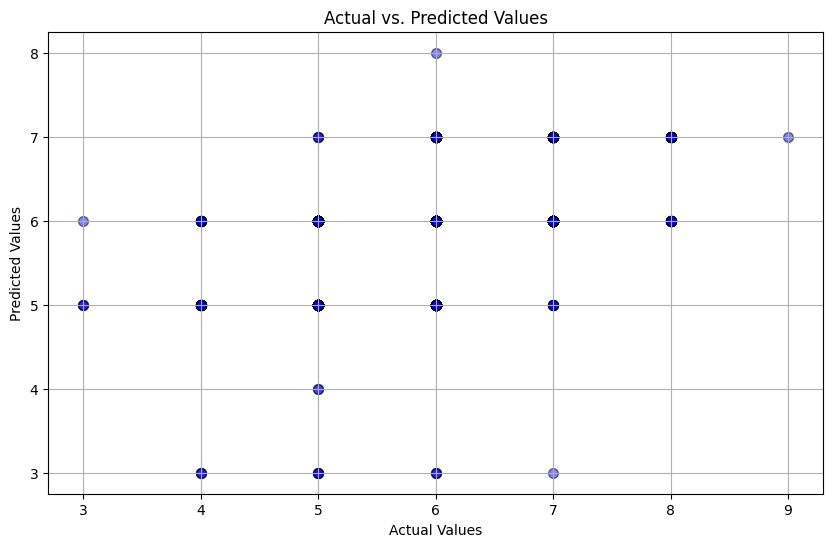

In [20]:
plot_predicted_actual_values(y_val,y_val_pred_nb)

In [21]:
y_train_pred_nb = best_model_nb.predict(X_train)
# Testiranje dobijenog modela na trening skupu
print("Naive-Bayes model errors on test set: ")
print_errors(y_train,y_train_pred_nb,'NB')


# Testiranje dobijenog modela na validacionom skupu
print("Naive-Bayes model errors on validation set: ")
model_nb = print_errors(y_val,y_val_pred_nb, 'NB')
models = models + [model_nb]

Naive-Bayes model errors on test set: 
Mean Squared Error:  0.7169617654606107
Mean Absolute Error:  0.5465742879137798
Root Mean Squared Error:  0.8467359478967518
R-squared:  0.06032606585007805
Median Absolute Error:  0.0
Explained Variance Score:  0.0604783024070461
Mean Absolute Percentage Error: 9.77%
Naive-Bayes model errors on validation set: 
Mean Squared Error:  0.6646153846153846
Mean Absolute Error:  0.5415384615384615
Root Mean Squared Error:  0.8152394645841089
R-squared:  0.12544433739742888
Median Absolute Error:  0.0
Explained Variance Score:  0.12669014318461191
Mean Absolute Percentage Error: 9.60%


### Analiza rezultata
Naive-Bayes model pokazuje loše rezultate na trening i validacionom skupu. Iako se performanse malo poboljšavaju na validacionom skupu u odnosu na trening, model generalno ima nisku sposobnost objašnjavanja varijanse u podacima i umerenu tačnost predviđanja.

Zanimljivo je da je medijana apsolutne greške 0. Ovo se dešava jer ovaj model uvek predviđa cele brojeve (što vidimo i na grafiku pravih i predviđenih vrednosti). Ovo sugeriše da model predviđa tačne vrednosti za bar polovinu podataka.

Dakle, model dobro radi za deo podataka, iako ukupna tačnost nije visoka. Ova karakteristika može ukazivati na to da model uspeva da precizno proceni određene podatke, dok u drugim slučajevima greške mogu biti značajne.

## SVR

In [22]:
# Hiperparametri
pipeline_svr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

param_grid_svr = {
    'pca__n_components': [8, 9, 10, 11],
    'svr__C': [0.01 ,0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 1],
    'svr__gamma' : ['scale','auto']
}

In [23]:
# Unakrsna validacija
grid_search_svr = model_selection.RandomizedSearchCV(pipeline_svr, param_grid_svr, n_iter = 50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
best_model_svr = grid_search_svr.best_score_

print("Best cross-validation score for SVR: ",best_model_svr)
print("Best parameters for SVR: ", grid_search_svr.best_params_)

Best cross-validation score for SVR:  -0.4810794523690876
Best parameters for SVR:  {'svr__gamma': 'auto', 'svr__epsilon': 0.2, 'svr__C': 1, 'pca__n_components': 11}


In [24]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_svr = grid_search_svr.best_estimator_
y_val_pred_svr = best_model_svr.predict(X_val)

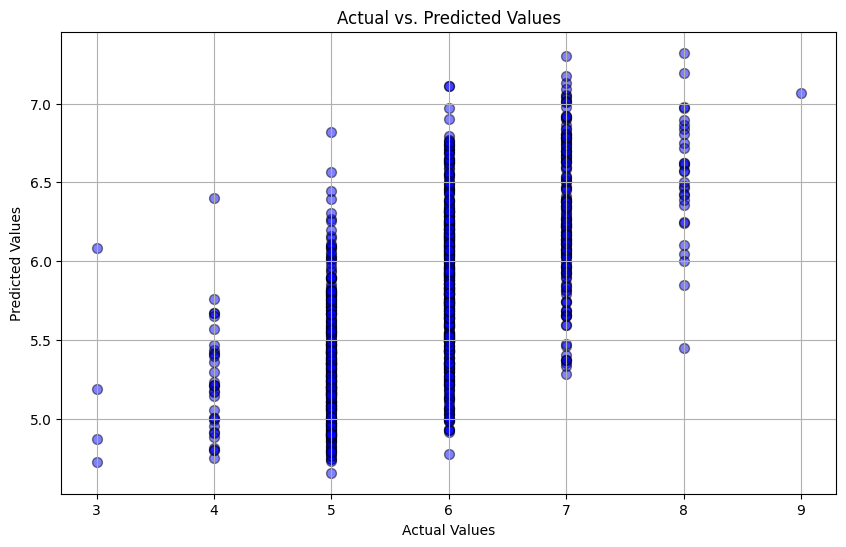

In [25]:
plot_predicted_actual_values(y_val,y_val_pred_svr)

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo četiri hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [26]:
import plotly.express as px

cv_results = pd.DataFrame(grid_search_svr.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [8,11],
                label = 'n_components', values = df['n_components']),
            dict(range= [0.01,100],
                 label='C', values = df['C']),
            dict(range = [0.01,1],
                label = 'epsilon', values = df['epsilon'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [27]:
# Testiranje dobijenog modela na trening skupu
y_train_pred_svr = best_model_svr.predict(X_train)
print("SVR model errors on training set: ")
print_errors(y_train,y_train_pred_svr,'SVR')

# Testiranje dobijenog modela na validacionom skupu
print("SVR model errors on validation set: ")
model_svr = print_errors(y_val,y_val_pred_svr,'SVR')
models = models + [model_svr]

SVR model errors on training set: 
Mean Squared Error:  0.40378754662611804
Mean Absolute Error:  0.4735776944588106
Root Mean Squared Error:  0.6354427957150179
R-squared:  0.47078261243799213
Median Absolute Error:  0.3333888074079523
Explained Variance Score:  0.4713396300637249
Mean Absolute Percentage Error: 8.39%
SVR model errors on validation set: 
Mean Squared Error:  0.4495257705211704
Mean Absolute Error:  0.5143823089659056
Root Mean Squared Error:  0.6704668302915293
R-squared:  0.4084769669865792
Median Absolute Error:  0.39740418684104206
Explained Variance Score:  0.4121918334964906
Mean Absolute Percentage Error: 9.04%


### Analiza rezultata
Analizom rezultata modela SVR, uočavamo da su greške na validacionom skupu nešto veće u poređenju sa greškama na trening skupu. Ove razlike su očekivane i ukazuju na to da model nije idealan u generalizaciji na neviđenim podacima, ali razlika nije dramatična, što sugeriše da model ima relativno dobar balans između preciznosti na trening i validacionom skupu.

## Slučajna šuma

In [28]:
# Hiperparametri
pipeline_rf = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', RandomForestRegressor())
])

param_grid_rf = {
    'pca__n_components': [8, 9, 10, 11],
    'regressor__n_estimators': [100, 150, 200],  # Number of trees in the forest
    'regressor__max_depth': [5, 8, 10],  # Maximum depth of the trees
    'regressor__min_samples_split': [20, 25, 30],  # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [12, 15, 18],    # Minimum number of samples required to be at a leaf node
}

In [29]:
# Unakrsna validacija
grid_search_rf = model_selection.RandomizedSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_score_

print("Best cross-validation score for Random Forest: ",best_model_rf)
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)

Best cross-validation score for Random Forest:  -0.4966903341440929
Best parameters for Random Forest:  {'regressor__n_estimators': 200, 'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 15, 'regressor__max_depth': 10, 'pca__n_components': 10}


In [30]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_rf = grid_search_rf.best_estimator_
y_val_pred_rf = best_model_rf.predict(X_val)

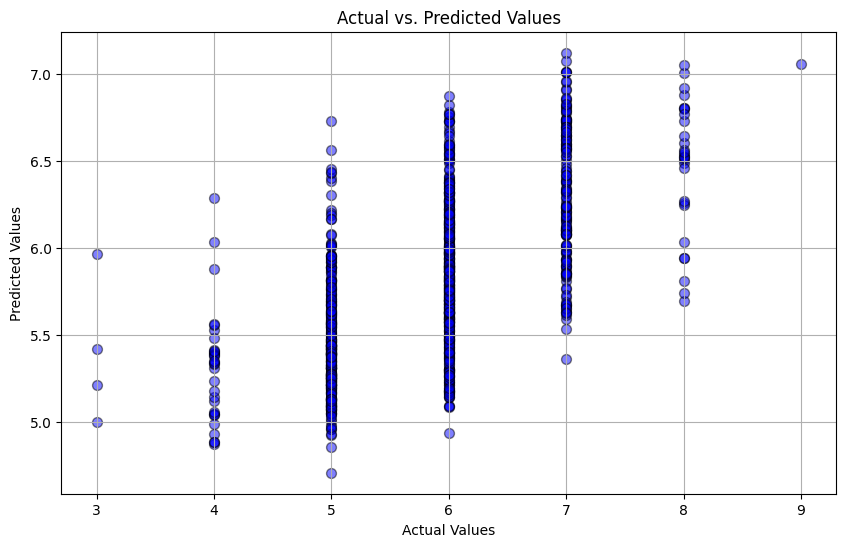

In [31]:
plot_predicted_actual_values(y_val,y_val_pred_rf)

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo pet hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [32]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

cv_results = pd.DataFrame(grid_search_rf.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [100,200],
                label = 'n_estimators', values = df['n_estimators']),
            dict(range= [5,10],
                 label='max_depth', values = df['max_depth']),
            dict(range = [20,30],
                label = 'min_samples_split', values = df['min_samples_split']),
            dict(range = [12,18],
                label = 'min_samples_leaf', values = df['min_samples_leaf'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [33]:
# Testiranje dobijenog modela na trening skupu
y_train_pred_rf = best_model_rf.predict(X_train)
print("Random Forest model errors on training set: ")
print_errors(y_train,y_train_pred_rf,'RF')

# Testiranje dobijenog modela na validacionom skupu
print("Random Forest model errors on validation set: ")
model_rf = print_errors(y_val,y_val_pred_rf,'RF')
models = models + [model_rf]

Random Forest model errors on training set: 
Mean Squared Error:  0.3487367501926243
Mean Absolute Error:  0.4531000847824758
Root Mean Squared Error:  0.5905393722628698
R-squared:  0.5429340170941579
Median Absolute Error:  0.3570657317577739
Explained Variance Score:  0.5429371194878739
Mean Absolute Percentage Error: 8.10%
Random Forest model errors on validation set: 
Mean Squared Error:  0.45050048089348105
Mean Absolute Error:  0.5205140077013302
Root Mean Squared Error:  0.6711933260197699
R-squared:  0.407194362798903
Median Absolute Error:  0.40479857686949305
Explained Variance Score:  0.4080289977532068
Mean Absolute Percentage Error: 9.22%


### Analiza rezultata
Rezultati modela Random Forest pokazuju da je došlo do blagog prekomernog prilagođavanja (overfittinga). Dok model postiže bolje rezultate na trening skupu (niži MSE, MAE, i RMSE) sa R-squared vrednošću od 0.545, isti model pokazuje lošije performanse na validacionom skupu (više MSE, MAE, i RMSE) sa R-squared vrednošću od 0.407. Ova razlika ukazuje na to da je model možda previše specijalizovan za trening podatke i ne generalizuje dovoljno dobro na nove podatke.

Da bismo poboljšali generalizaciju i smanjili overfitting, možemo razmotriti povećanje min_samples_split i min_samples_leaf, ograničavanje max_depth, kao i primenu dodatnih tehnika regularizacije kako bismo smanjili kompleksnost modela i poboljšali njegovu sposobnost generalizacije.

## Adaboost

In [34]:
# Hiperparametri
pipeline_ab = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', AdaBoostRegressor())
])

param_grid_ab = {
    'pca__n_components': [8, 9, 10, 11],
    'regressor__n_estimators': [10, 100, 1000, 2000],  # Number of boosting stages
    'regressor__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],  # Learning rate shrinks the contribution of each tree
}

In [35]:
# Unakrsna validacija
grid_search_ab = model_selection.GridSearchCV(pipeline_ab, param_grid_ab, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ab.fit(X_train, y_train)
best_model_ab = grid_search_ab.best_score_

print("Best cross-validation score for Adaboost: ",best_model_ab)
print("Best parameters for AdaBoost: ", grid_search_ab.best_params_)

Best cross-validation score for Adaboost:  -0.5662167422824337
Best parameters for AdaBoost:  {'pca__n_components': 9, 'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}


In [36]:
# Predikcija ciljne promenljive na validacionom skupu koristeći najbolji model
best_model_ab = grid_search_ab.best_estimator_
y_val_pred_ab = best_model_ab.predict(X_val)

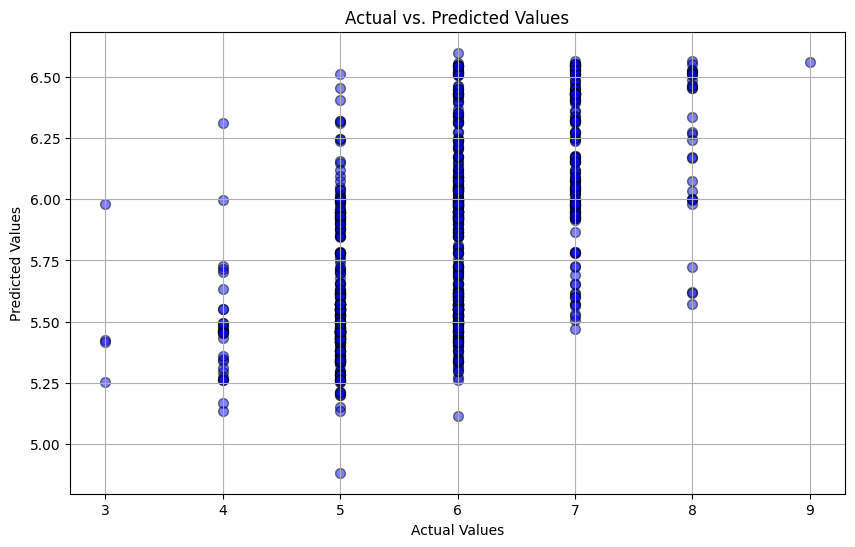

In [37]:
plot_predicted_actual_values(y_val,y_val_pred_ab)

### Provera parametara na toplotnoj mapi
Možemo da koristimo toplotne mape da se uverimo da pretražujemo dobre skupove parametara. Iz ovih rezultata vidimo da možemo pretraživati i veće vrednosti za *regressor__n_estimators* parametar.

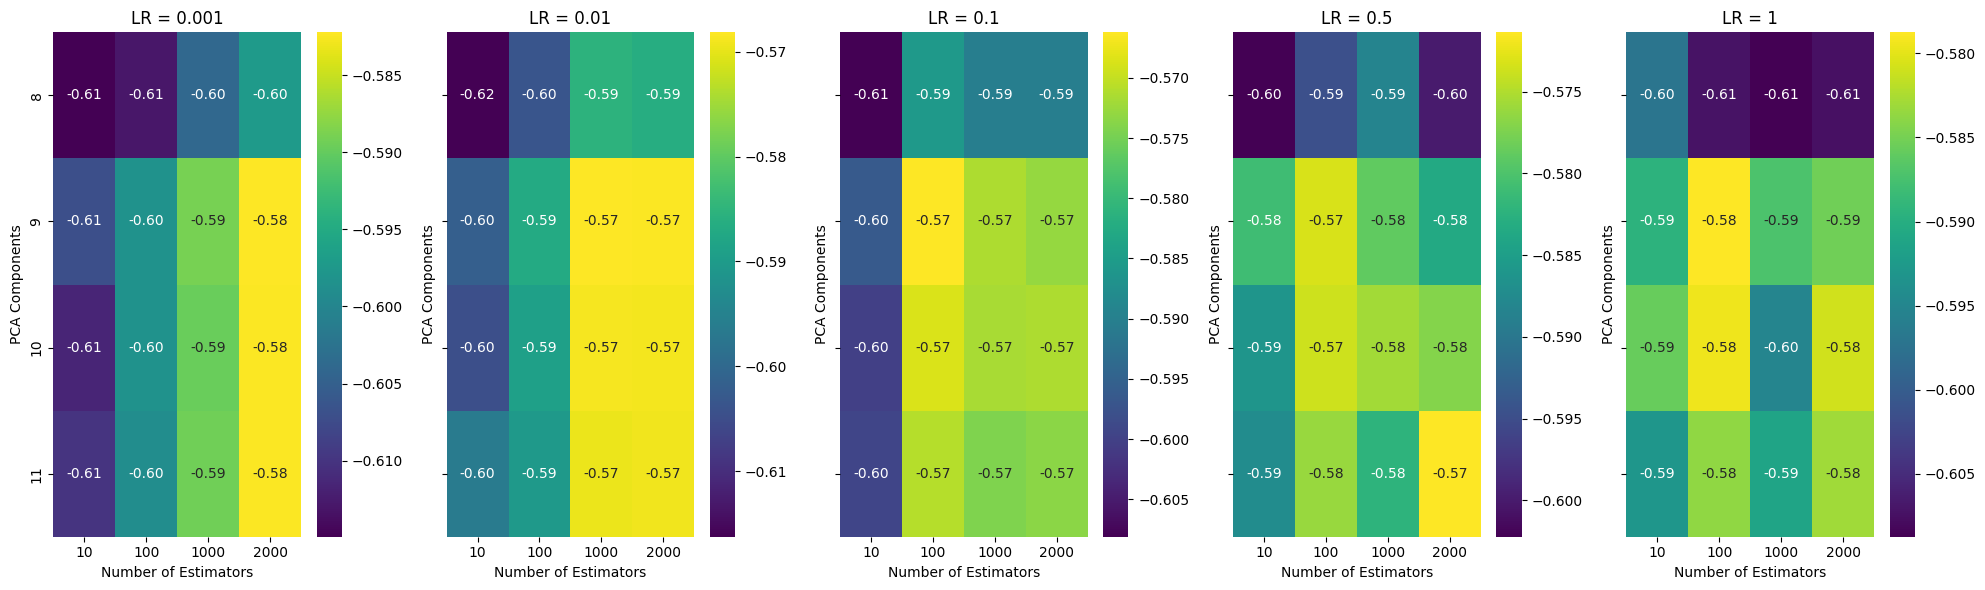

In [38]:
cv_results = pd.DataFrame(grid_search_ab.cv_results_)

cv_test_score = cv_results['mean_test_score'].values.reshape(5,4,4)

n_components = [8, 9, 10, 11]
n_estimators = [10, 100, 1000, 2000]
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]

fig, axs = plt.subplots(nrows=1, ncols=len(learning_rates), figsize=(20, 6), sharey=True)

# Iscrtavanje toplotnih mapa
for i, lr in enumerate(learning_rates):
    scores = cv_results[cv_results['param_regressor__learning_rate'] == lr]['mean_test_score'].values
    scores = scores.reshape(len(n_components), len(n_estimators))

    sb.heatmap(scores, xticklabels=n_estimators, yticklabels=n_components, cmap='viridis', annot=True, fmt='.2f', ax=axs[i])
    axs[i].set_xlabel('Number of Estimators')
    axs[i].set_ylabel('PCA Components')
    axs[i].set_title(f'LR = {lr}')

# Adjust layout
plt.tight_layout()
plt.show()

In [39]:
# Testiranje dobijenog modela na trening skupu
y_train_pred_ab = best_model_ab.predict(X_train)
print("Adaboost model errors on training set: ")
print_errors(y_train,y_train_pred_ab,'AB')

# Testiranje dobijenog modela na validacionom skupu
print("AdaBoost model errors on validation set: ")
model_ab = print_errors(y_val,y_val_pred_ab, 'AB')
models = models + [model_ab]

Adaboost model errors on training set: 
Mean Squared Error:  0.5314835056293472
Mean Absolute Error:  0.579314221941077
Root Mean Squared Error:  0.7290291527979846
R-squared:  0.3034200417233286
Median Absolute Error:  0.4811912225705326
Explained Variance Score:  0.3038155960302542
Mean Absolute Percentage Error: 10.37%
AdaBoost model errors on validation set: 
Mean Squared Error:  0.5267644611689384
Mean Absolute Error:  0.5800236363742057
Root Mean Squared Error:  0.7257854098622667
R-squared:  0.3068399362441975
Median Absolute Error:  0.48159509202453954
Explained Variance Score:  0.30689892178208844
Mean Absolute Percentage Error: 10.33%


### Analiza rezultata

Analiza rezultata modela AdaBoost pokazuje da se performanse na testnom i validacionom skupu podataka gotovo ne razlikuju, što sugeriše da model generalizuje dobro na neviđenim podacima. Iako su rezultati prilično stabilni između skupa za obuku i validacionog skupa, vrednosti metrika kao što su R-squared i Mean Squared Error su relativno niske, što ukazuje na to da model objašnjava samo mali deo varijanse u podacima. Konkretno, R-squared vrednosti su oko 0.30, što sugeriše da model ne uspeva u potpunosti da uhvati ključne obrasce u podacima i da postoji značajna količina neobjašnjene varijanse.

## Izbor najboljeg modela

Sada uporedimo greške svih korišćenih metoda kako bismo izabrali finalni model koji će biti testiran na test skupu.

Vidimo da Random Forest i SVR modeli ima najbolje rezultate po svakoj metrici. Random Forest biramo za finalni model.

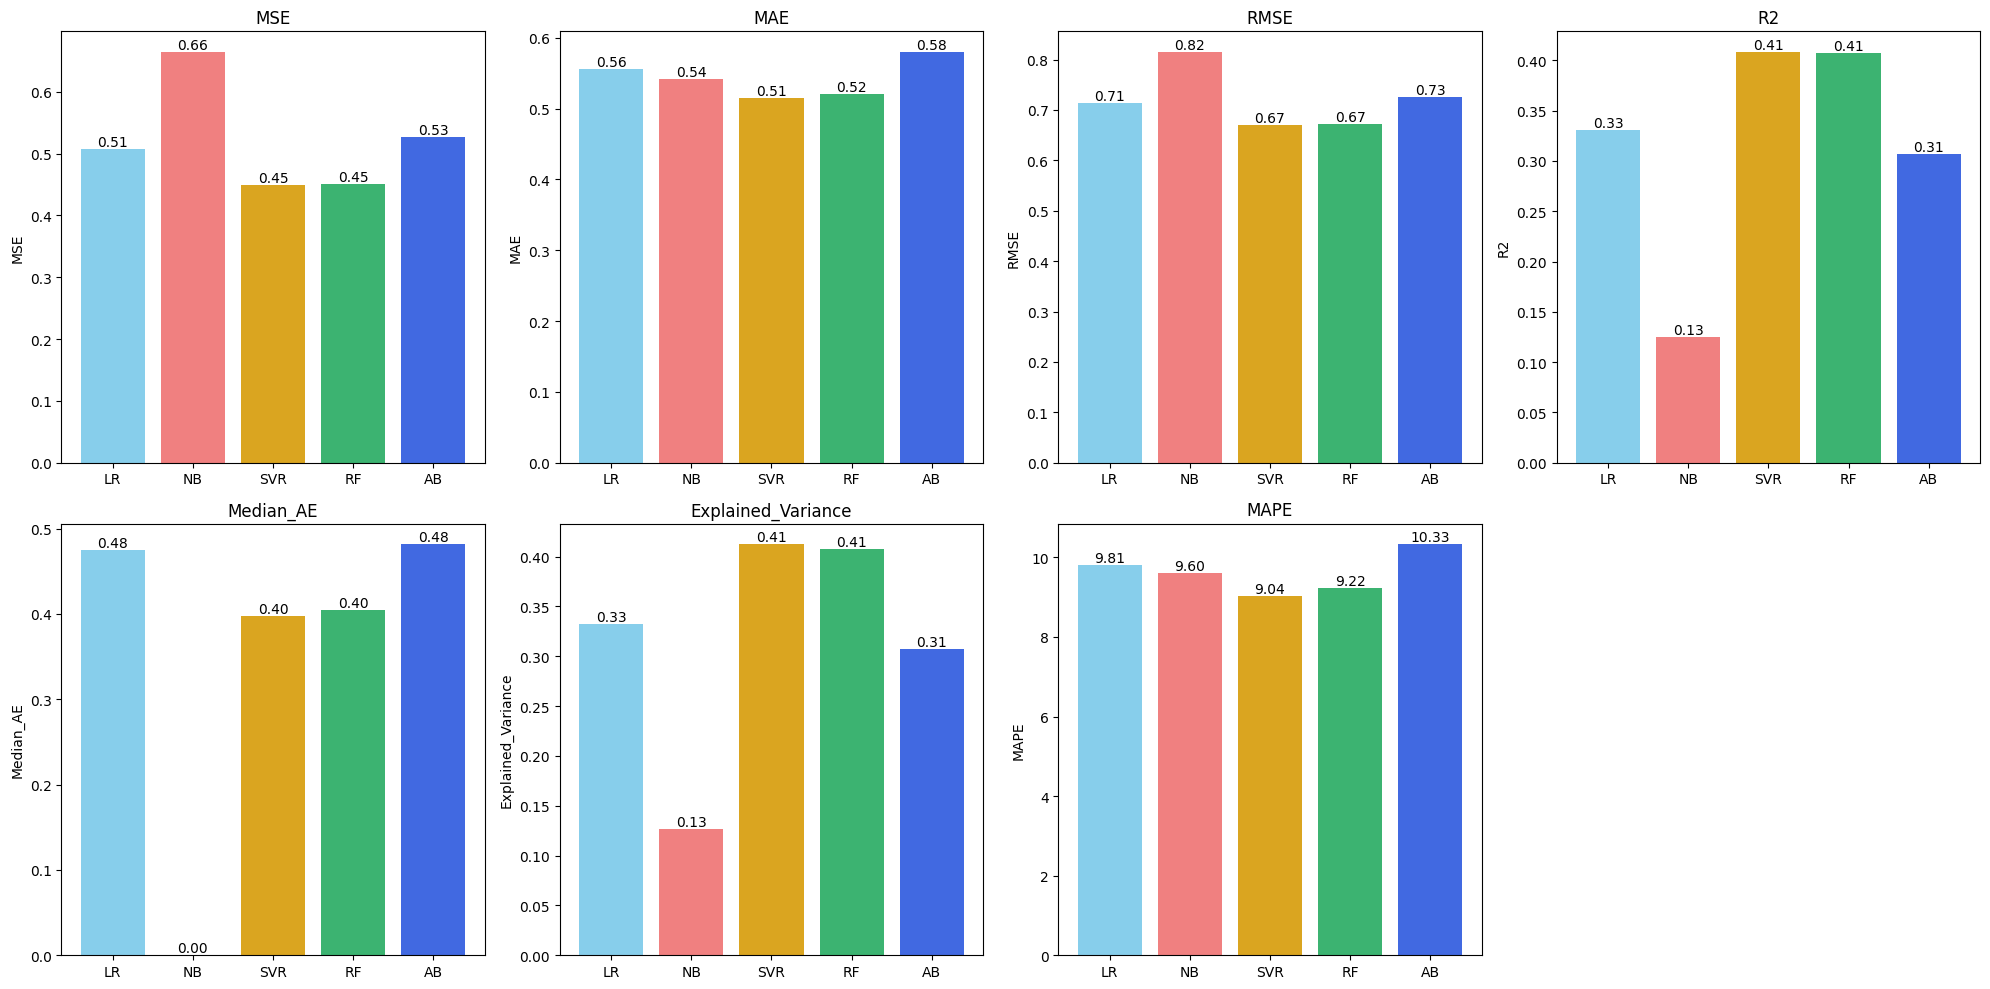

In [40]:
metric_names = ['MSE', 'MAE', 'RMSE', 'R2', 'Median_AE', 'Explained_Variance', 'MAPE']

model_names = [model["Model"] for model in models]
metric_values = {metric: [model[metric] for model in models] for metric in metric_names}

colors = [
    "skyblue",
    "lightcoral",
    "goldenrod",
    "mediumseagreen",
    "royalblue"
]

# Kreireamo histogram za svaku metriku
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, metric in enumerate(metric_names):
    row = i // 4
    col = i % 4

    bars = axs[row, col].bar(model_names, metric_values[metric], color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel(metric)

    # Tekst iznad barova
    for bar in bars:
        height = bar.get_height()
        axs[row, col].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

axs[1, 3].axis('off')

plt.tight_layout()
plt.show()

Na ovom grafiku prikazujemo REC (Regression Error Characteristic) krivu za različite regresione modele. Grafikon prikazuje kako se tačnost modela menja u zavisnosti od nivoa tolerancije na greške.

Na X-osi je prikazana tolerancija, što predstavlja maksimalnu dozvoljenu grešku između stvarnih i predviđenih vrednosti. Na Y-osi je prikazana tačnost, koja pokazuje koliki deo predikcija modela zadovoljava ovu toleranciju.

Svaka linija na grafiku predstavlja jedan od modela (LR, NB, SVR, RF, AB) i pokazuje kako se njegova tačnost menja sa promenom nivoa tolerancije.

Na REC krivama, Naive Bayes model prikazuje skokovit obrazac zbog svojih celobrojnih predikcija. Ovaj model se pokazuje kao najbolji sa tolerancijom od 1. Random Forest i SVR imaju generalno najbolje rezultate.

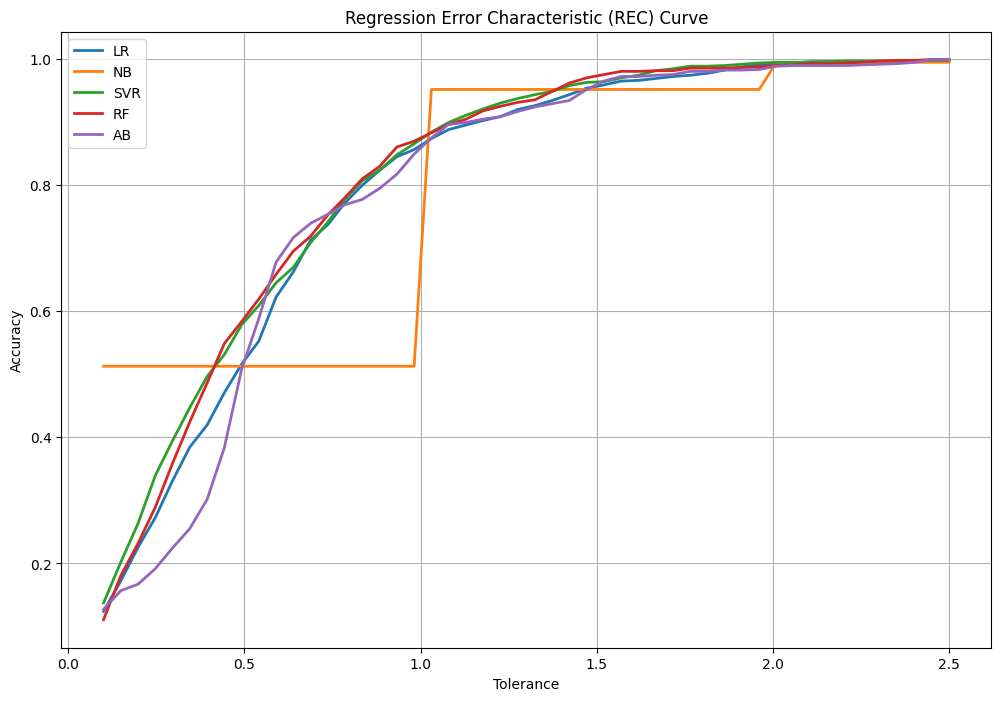

In [41]:
def calculate_accuracy_with_tolerance(true_values, predictions, tolerance):
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    return np.mean(np.abs(true_values - predictions) <= tolerance)

tolerances = np.linspace(0.1, 2.5, 50)
accuracies = [[calculate_accuracy_with_tolerance(y_val, y_val_pred_lr, tol) for tol in tolerances]
  ,[calculate_accuracy_with_tolerance(y_val, y_val_pred_nb, tol) for tol in tolerances]
  ,[calculate_accuracy_with_tolerance(y_val, y_val_pred_svr, tol) for tol in tolerances]
  ,[calculate_accuracy_with_tolerance(y_val, y_val_pred_rf, tol) for tol in tolerances]
  ,[calculate_accuracy_with_tolerance(y_val, y_val_pred_ab, tol) for tol in tolerances]]
names = ['LR','NB','SVR','RF','AB']

# Plot REC Curve for all models
plt.figure(figsize=(12, 8))

for i in range(5):
    plt.plot(tolerances, accuracies[i], lw=2, label=names[i])

plt.xlabel('Tolerance')
plt.ylabel('Accuracy')
plt.title('Regression Error Characteristic (REC) Curve')
plt.grid(True)
plt.legend()
plt.show()

Zaključujemo da metoda slučajne šume postiže najbolje rezultate na validacionom skupu u svim metrikama koje smo koristili. Stoga ćemo ovaj model izabrati kao finalni. Sledeći korak je da ponovo obučimo model koristeći objedinjeni trening i validacioni skup, a zatim ćemo ga evaluirati na test skupu

## Retreniranje na trening i validacionom skupu

In [42]:
# Standardizacija podataka koristeći uniju trening i validacionog skupa
final_scaler = StandardScaler()
X_train_validation = final_scaler.fit_transform(X_train_validation)
X_test = final_scaler.transform(X_test)

In [43]:
# Retreniranje najboljeg modela koristeci uniju skupova za trening i validaciju
best_model = grid_search_rf
pca = PCA(n_components=best_model.best_params_['pca__n_components'])
regressor = RandomForestRegressor(n_estimators = best_model.best_params_['regressor__n_estimators'], max_depth = best_model.best_params_['regressor__max_depth'],
                                  min_samples_split=best_model.best_params_['regressor__min_samples_split'],min_samples_leaf = best_model.best_params_['regressor__min_samples_leaf'])
# Hiperparametri
pipeline_final = Pipeline([
    ('pca', pca),
    ('regressor', regressor)
])

pipeline_final.fit(X_train_validation,y_train_validation)

Pipeline(steps=[('pca', PCA(n_components=10)),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=15,
                                       min_samples_split=20,
                                       n_estimators=200))])

In [44]:
# Predikcija ciljne promenljive na test skupu koristeći finalni model
y_test_pred = best_model.predict(X_test)

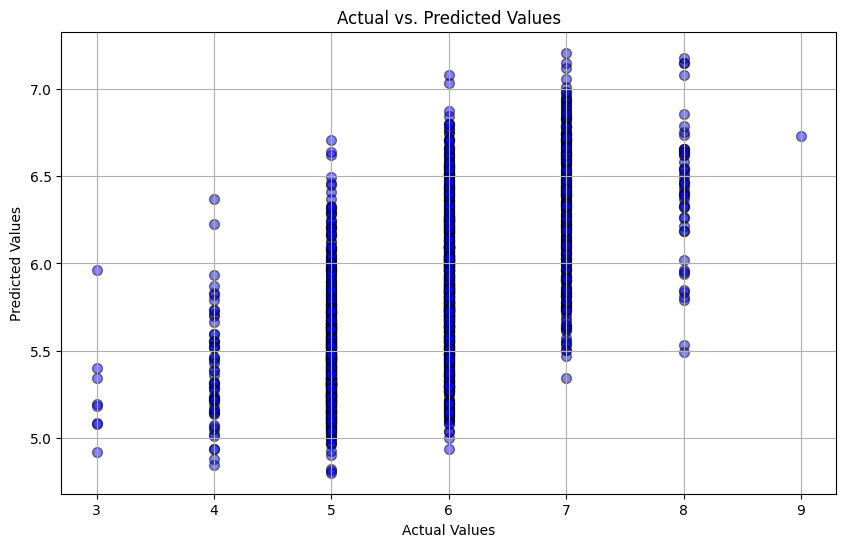

In [45]:
plot_predicted_actual_values(y_test,y_test_pred)

## Testiranje finalnog modela na test skupu
Vidimo da su rezultati modela na test skupu blago gori nego na validacionom skupu, što znači da model verovatno nismo preprilagodili.

Konačni model pokazuje solidne rezultate na test skupu. Srednja kvadratna greška (MSE) od 0.448 ukazuje na to da se predikcije u proseku umereno razlikuju od stvarnih vrednosti. Srednja apsolutna greška (MAE) od 0.518 pokazuje da je prosečna apsolutna razlika između predikcija i stvarnih vrednosti oko 0.518.

Koren srednje kvadratne greške (RMSE) od 0.669 daje uvid u prosečnu veličinu grešaka predikcije, pokazujući da su greške generalno male, ali ne zanemarljive. R-kvadrat vrednost od 0.413 znači da model objašnjava oko 41.3% varijance ciljne varijable,.

Medijanska apsolutna greška od 0.415 sugeriše da je bar polovina predikcija unutar 0.415 od stvarnih vrednosti, što je dobar rezultat. Objašnjena varijansa od 0.413 potvrđuje sličan nivo objašnjenja kao R-kvadrat.

Na kraju, srednja apsolutna procentualna greška (MAPE) od 9.28% pokazuje da je prosečna greška predikcija oko 9.28% stvarnih vrednosti, što je relativno nisko i ukazuje na dobru tačnost.

U celini, model se pokazuje zadovoljavajuće, ali ima prostora za dalja poboljšanja.

In [46]:
# Testiranje finalong modela na test skupu
print("Final model errors on test set: ")
model_final = print_errors(y_test,y_test_pred, 'Final model')

Final model errors on test set: 
Mean Squared Error:  0.47102656357177397
Mean Absolute Error:  0.5330828966063317
Root Mean Squared Error:  0.6863137500966843
R-squared:  0.3824042355496544
Median Absolute Error:  0.43368148377186433
Explained Variance Score:  0.38244060689908665
Mean Absolute Percentage Error: 9.52%


### Značaj pojedinačnih atributa
S obzirom da smo koristili PCA, treba mapirati važnost novih atributa na važnost originalnih atributa.

Vidimo da je količina alkohola u vinu atribut koji najviše utiče na kvalitet vina, dok sadržaj slobodnog sumpor-dioksida najmanje utiče na kvalitet vina.


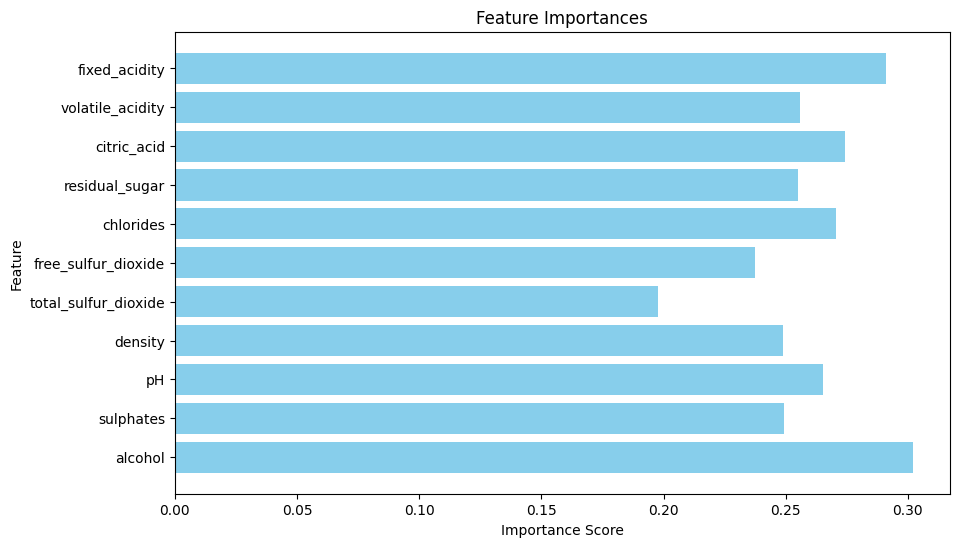

In [47]:
pca = pipeline_final.named_steps['pca']
rf = pipeline_final.named_steps['regressor']
original_feature_names = wine_quality.data.headers.to_numpy()[:-2]

components = abs(pca.components_)
importances_pca = rf.feature_importances_ # važnost novih atributa

importance_scores = np.abs(components.T @ importances_pca) # doprinos originalnih atributa u važnosti novih atributa

plt.figure(figsize=(10, 6))
plt.barh(original_feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Čuvanje finalnog modela

In [56]:
model_filename='models/model_rf.pickle'

In [57]:
with open(model_filename, 'wb') as pickle_file:
    pickle.dump(best_model,pickle_file)

In [58]:
scaler_filename='models/scalar_rf.pickle'

In [59]:
with open(scaler_filename, 'wb') as pickle_file:
    pickle.dump(scaler,pickle_file)

In [60]:
pca_filename='models/pca_rf.pickle'

In [61]:
with open(pca_filename, 'wb') as pickle_file:
    pickle.dump(scaler,pickle_file)